# Counting Labels & Weighted Loss Function

As you saw in the lecture videos, one way to avoid having class imbalance impact the loss function is to weight the losses differently.  To choose the weights, you first need to calculate the class frequencies.

For this exercise, you'll just get the count of each label.  Later on, you'll use the concepts practiced here to calculate frequencies in the assignment!

As before, calculate the two terms that make up the loss function.  Notice that you are working with more than one class (represented by columns).  In this case, there are two classes.

Start by calculating the loss for class `0`.

$$ loss^{(i)} = loss_{pos}^{(i)} + los_{neg}^{(i)} $$

$$loss_{pos}^{(i)} = -1 \times weight_{pos}^{(i)} \times y^{(i)} \times log(\hat{y}^{(i)})$$

$$loss_{neg}^{(i)} = -1 \times weight_{neg}^{(i)} \times (1- y^{(i)}) \times log(1 - \hat{y}^{(i)})$$

# Compute class weights with scikit learn

In [1]:
import os
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from pprint import pprint
import matplotlib.pyplot as plt

## Create text labels

In [2]:
train_df = pd.read_csv("data/nih/train-small.csv")
valid_df = pd.read_csv("data/nih/valid-small.csv")
test_df  = pd.read_csv("data/nih/test.csv")

labels_text = list(train_df.drop(['Image','PatientId'], axis=1).columns)
labels_text

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

## Create datasets in Numpy instead of Tensorflow

In [3]:
X_train            = []
image_dir          = "data/nih/images-small/"
target_w, target_h = 320, 320
batch_size         = 16

for i in range(len(train_df['Image'])):
    image = tf.keras.preprocessing.image.load_img(os.path.join(image_dir, train_df['Image'].iloc[i]), target_size=(target_w, target_h))
    image = tf.keras.preprocessing.image.img_to_array(image)
    X_train.append(image)

X_train = np.array(X_train).astype(np.float32)

y_train = train_df[labels_text].values.astype(np.int32)  # Get the multi-label output

X_valid = []
for i in range(len(valid_df['Image'])):
    image = tf.keras.preprocessing.image.load_img(os.path.join(image_dir, valid_df['Image'].iloc[i]), target_size=(target_w, target_h))
    image = tf.keras.preprocessing.image.img_to_array(image)
    X_valid.append(image)

X_valid = np.array(X_valid).astype(np.float32)

y_valid = valid_df[labels_text].values.astype(np.int32)  # Get the multi-label output

X_test = []

for i in range(len(test_df['Image'])):
    image = tf.keras.preprocessing.image.load_img(os.path.join(image_dir, train_df['Image'].iloc[i]), target_size=(target_w, target_h))
    image = tf.keras.preprocessing.image.img_to_array(image)
    X_test.append(image)

X_test = np.array(X_test).astype(np.float32)

y_test = test_df[labels_text].values.astype(np.int32)  # Get the multi-label output

## Calculate class weights and sample weights

In [4]:
# Step 1: Calculate class weights for each label column
class_weights_dict = {}
for label in labels_text:
    label_values  = train_df[label].values
    class_weights = sklearn.utils.class_weight.compute_class_weight(
                                                                    class_weight='balanced',
                                                                    classes=np.unique(label_values),
                                                                    y=label_values
                                                                )
    class_weights_dict[label] = dict(zip(np.unique(label_values), class_weights))

print("class_weights:")
print(f"{len(class_weights) = }")
pprint(class_weights)
print("\nclass_weights_dict:")
pprint(class_weights_dict)

# Step 2: Create sample weights based on class weights for each label column
sample_weights = np.ones(y_train.shape[0])  # Start with weights of 1 for each sample

# Apply weights for each class column
for i, label in enumerate(labels_text):
    class_weights = class_weights_dict[label]
    # Multiply sample weights by the class weights for the label
    sample_weights *= np.where(y_train[:, i] == 1, class_weights[1], class_weights[0])

print("\nsample_weights:")
print(f"{len(X_train) = }        {X_train.shape = }")
print(f"{len(sample_weights) = } {sample_weights.shape = }\n")
pprint(sample_weights[:12])

# Get a list of the 0 weights
zero_weights = [weights[0] for weights in class_weights_dict.values()]

# Get a list of the 1 weights
one_weights = [weights[1] for weights in class_weights_dict.values()]

class_weights:
len(class_weights) = 2
array([ 0.51975052, 13.15789474])

class_weights_dict:
{'Atelectasis': {0: 0.5592841163310962, 1: 4.716981132075472},
 'Cardiomegaly': {0: 0.5102040816326531, 1: 25.0},
 'Consolidation': {0: 0.5170630816959669, 1: 15.151515151515152},
 'Edema': {0: 0.508130081300813, 1: 31.25},
 'Effusion': {0: 0.573394495412844, 1: 3.90625},
 'Emphysema': {0: 0.5065856129685917, 1: 38.46153846153846},
 'Fibrosis': {0: 0.5070993914807302, 1: 35.714285714285715},
 'Hernia': {0: 0.501002004008016, 1: 250.0},
 'Infiltration': {0: 0.6060606060606061, 1: 2.857142857142857},
 'Mass': {0: 0.5235602094240838, 1: 11.11111111111111},
 'Nodule': {0: 0.5285412262156448, 1: 9.25925925925926},
 'Pleural_Thickening': {0: 0.5107252298263534, 1: 23.80952380952381},
 'Pneumonia': {0: 0.5050505050505051, 1: 50.0},
 'Pneumothorax': {0: 0.5197505197505198, 1: 13.157894736842104}}

sample_weights:
len(X_train) = 1000        X_train.shape = (1000, 320, 320, 3)
len(sample_weights) = 1000 

## If you multiply the class weights times the number of 0s and 1s, this is what you get

Which makes more sense to me than setting the positive and negative contributions equal to each other in some mystical way as is done in the example in the course

In [5]:
weighted_zeros = {}
weighted_ones = {}

# Iterate through each class in the weights dictionary
for class_name, weights in class_weights_dict.items():
    # Get the column from the DataFrame
    class_column = train_df[class_name]

    # Count the number of 0s and 1s
    counts = class_column.value_counts()

    # Get the count of 0s and 1s, defaulting to 0 if not found
    num_zeros = counts.get(0, 0)
    num_ones = counts.get(1, 0)

    # Calculate the weighted counts for 0s and 1s separately
    weighted_zeros[class_name] = num_zeros * weights[0]
    weighted_ones[class_name]  = num_ones * weights[1]

# Create a combined DataFrame
combined_counts_df = pd.DataFrame({
    'Class': list(weighted_zeros.keys()),
    'Weighted_Zero_Count': list(weighted_zeros.values()),
    'Weighted_One_Count': list(weighted_ones.values())
})

# Display the combined DataFrame
print(combined_counts_df)

                 Class  Weighted_Zero_Count  Weighted_One_Count
0          Atelectasis                500.0               500.0
1         Cardiomegaly                500.0               500.0
2        Consolidation                500.0               500.0
3                Edema                500.0               500.0
4             Effusion                500.0               500.0
5            Emphysema                500.0               500.0
6             Fibrosis                500.0               500.0
7               Hernia                500.0               500.0
8         Infiltration                500.0               500.0
9                 Mass                500.0               500.0
10              Nodule                500.0               500.0
11  Pleural_Thickening                500.0               500.0
12           Pneumonia                500.0               500.0
13        Pneumothorax                500.0               500.0


# Try (and fail) to reproduce the analysis in the class notebook

In [6]:
class_counts = train_df.loc[:,labels_text].sum()
display(class_counts)

Atelectasis           106
Cardiomegaly           20
Consolidation          33
Edema                  16
Effusion              128
Emphysema              13
Fibrosis               14
Hernia                  2
Infiltration          175
Mass                   45
Nodule                 54
Pleural_Thickening     21
Pneumonia              10
Pneumothorax           38
dtype: int64

In [7]:
labels_numeric = train_df.loc[:,labels_text]
print(f"{labels_numeric.shape = }")

positive_frequencies =     np.sum(labels_numeric / labels_numeric.shape[0] ,axis=0)
negative_frequencies = 1 - np.sum(labels_numeric / labels_numeric.shape[0] ,axis=0)

labels_numeric.shape = (1000, 14)


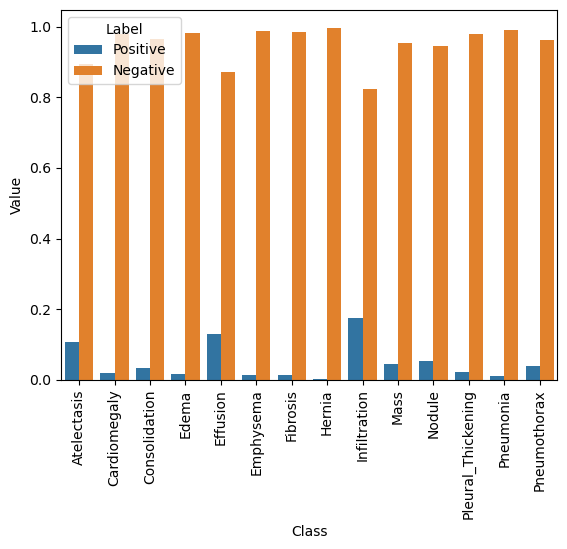

In [8]:
data = pd.DataFrame({"Class": labels_text, "Label": "Positive", "Value": positive_frequencies})
data = pd.concat([data, pd.DataFrame([{"Class": labels_text[l], "Label": "Negative", "Value": v} for l, v in enumerate(negative_frequencies)])], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

plt.show()

### What the fuck this means, I do not know

In [9]:
freq_pos =     np.sum(labels_numeric / labels_numeric.shape[0] ,axis=0)
freq_neg = 1 - np.sum(labels_numeric / labels_numeric.shape[0] ,axis=0)

pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

In [10]:
# Calculate positive and negative weights
w_p = np.sum(labels_numeric == 0, axis=0) / labels_numeric.shape[0]
w_n = np.sum(labels_numeric == 1, axis=0) / labels_numeric.shape[0]

In [18]:
print("w_p      =     np.sum(labels_numeric == 0, axis=0) / labels_numeric.shape[0]")
print("w_n      =     np.sum(labels_numeric == 1, axis=0) / labels_numeric.shape[0]\n")
print("freq_pos =     np.sum(labels_numeric / labels_numeric.shape[0] ,axis=0)")
print("freq_neg = 1 - np.sum(labels_numeric / labels_numeric.shape[0] ,axis=0)\n")
print("w_p == freq_neg, w_n == freq_pos\n")

class_data = pd.DataFrame({
    #'Class': list(weighted_zeros.keys()),
    'ones': class_counts,
    'zeros': 1000 - class_counts,
    'freq_pos': list(freq_pos),
    'freq_neg': list(freq_neg),
    'freq_pos * freq_neg': freq_pos * freq_neg,
    'pos_contrib': list(pos_contribution),
    'neg_contrib': list(neg_contribution),
    'w_p': list(w_p),
    'w_n': list(w_n),
    'w_p * w_n': list(w_p * w_n),
    'one_weights': one_weights,
    'zero_weights': zero_weights
    
})
display(class_data)

w_p      =     np.sum(labels_numeric == 0, axis=0) / labels_numeric.shape[0]
w_n      =     np.sum(labels_numeric == 1, axis=0) / labels_numeric.shape[0]

freq_pos =     np.sum(labels_numeric / labels_numeric.shape[0] ,axis=0)
freq_neg = 1 - np.sum(labels_numeric / labels_numeric.shape[0] ,axis=0)

w_p == freq_neg, w_n == freq_pos



,ones,zeros,freq_pos,freq_neg,freq_pos * freq_neg,pos_contrib,neg_contrib,w_p,w_n,w_p * w_n,one_weights,zero_weights
Atelectasis,106,894,0.106,0.894,0.094764,0.094764,0.094764,0.894,0.106,0.094764,4.716981,0.559284
Cardiomegaly,20,980,0.020,0.980,0.019600,0.019600,0.019600,0.980,0.020,0.019600,25.000000,0.510204
Consolidation,33,967,0.033,0.967,0.031911,0.031911,0.031911,0.967,0.033,0.031911,15.151515,0.517063
Edema,16,984,0.016,0.984,0.015744,0.015744,0.015744,0.984,0.016,0.015744,31.250000,0.508130
Effusion,128,872,0.128,0.872,0.111616,0.111616,0.111616,0.872,0.128,0.111616,3.906250,0.573394
Emphysema,13,987,0.013,0.987,0.012831,0.012831,0.012831,0.987,0.013,0.012831,38.461538,0.506586
Fibrosis,14,986,0.014,0.986,0.013804,0.013804,0.013804,0.986,0.014,0.013804,35.714286,0.507099
Hernia,2,998,0.002,0.998,0.001996,0.001996,0.001996,0.998,0.002,0.001996,250.000000,0.501002
Infiltration,175,825,0.175,0.825,0.144375,0.144375,0.144375,0.825,0.175,0.144375,2.857143,0.606061
Mass,45,955,0.045,0.955,0.042975,0.042975,0.042975,0.955,0.045,0.042975,11.111111,0.523560


### whatever, looks like a tautology to me

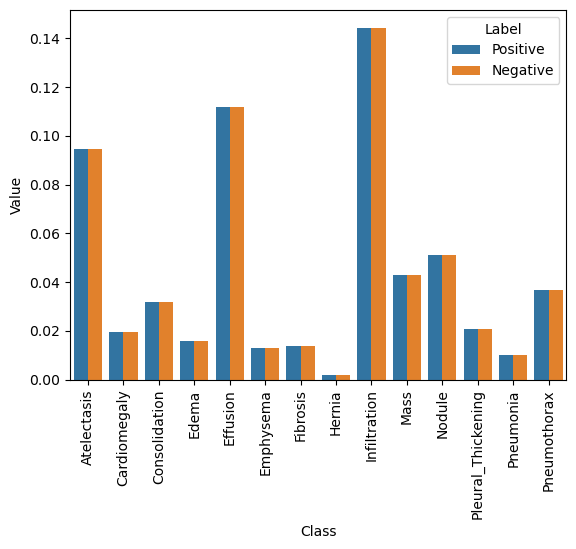

In [12]:
data = pd.DataFrame({"Class": labels_text, "Label": "Positive", "Value": pos_contribution})
new_rows = pd.DataFrame([{"Class": labels_text[l], "Label": "Negative", "Value": v}
                         for l, v in enumerate(neg_contribution)])

# Use pd.concat to combine DataFrames
data = pd.concat([data, new_rows], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

plt.show()

## Train a basic CNN

In [13]:
# Step 1: Create a Keras model 
def create_cnn():
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(shape=(target_w, target_h, 3)),
        tf.keras.layers.Rescaling(scale=1.0/255.0),
        
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.7),
        
        tf.keras.layers.Dense(14, activation='sigmoid')  # 14 output nodes for multi-label classification
    ])
    return model

In [14]:
model = create_cnn()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=20,
                                                  verbose=1,
                                                  mode='min',
                                                  restore_best_weights=True)

# Step 2: Train the model using sample weights
history = model.fit(
    X_train,
    y_train,
    # =========================================================
    sample_weight=sample_weights,  # Include the sample weights
    # =========================================================
    epochs=1000,
    validation_data=[X_valid, y_valid],
    callbacks=[early_stopping])

2024-10-05 21:33:12.781984: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-10-05 21:33:12.782014: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-10-05 21:33:12.782019: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-10-05 21:33:12.782035: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-05 21:33:12.782044: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/1000


2024-10-05 21:33:14.151890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 232ms/step - accuracy: 0.1307 - loss: 4.0860 - val_accuracy: 0.0000e+00 - val_loss: 0.8693
Epoch 2/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 209ms/step - accuracy: 0.1883 - loss: 0.3208 - val_accuracy: 0.0826 - val_loss: 1.0186
Epoch 3/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 210ms/step - accuracy: 0.1151 - loss: 1.0824 - val_accuracy: 0.1468 - val_loss: 0.5613
Epoch 4/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 211ms/step - accuracy: 0.0772 - loss: 0.5738 - val_accuracy: 0.0183 - val_loss: 1.7553
Epoch 5/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 210ms/step - accuracy: 0.0463 - loss: 0.1506 - val_accuracy: 0.0826 - val_loss: 0.5632
Epoch 6/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - accuracy: 0.0717 - loss: 0.1602 - val_accuracy: 0.0917 - val_loss: 0.8617
Epoch 7/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 210ms/step - accuracy: 0.0743 - loss: 0.0167 - val_accuracy: 0.0917 - val_loss: 0.6616
Epoch 8/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 209ms/step - accuracy: 0.1111 - loss: 0.0144 - val_accur

In [15]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

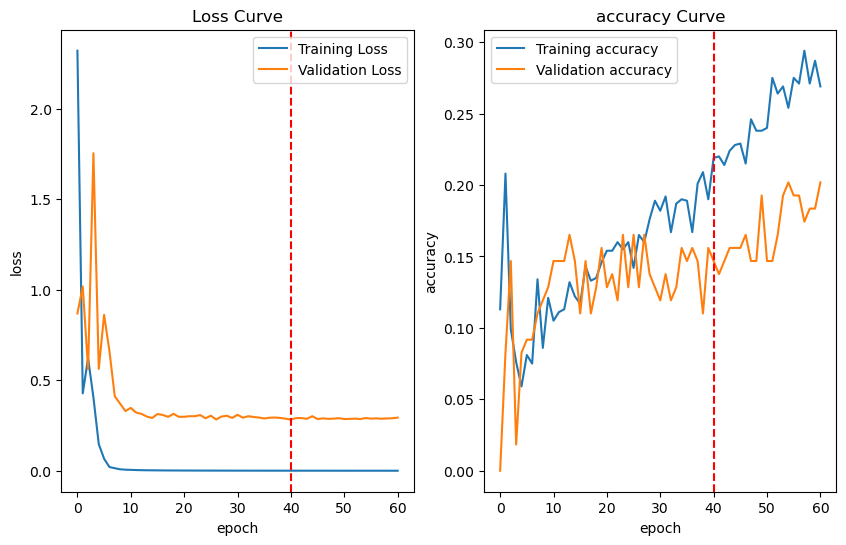

In [16]:
def plot_loss_accuracy(history,best_epoch=early_stopping.best_epoch):
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,6))
    
    ax1.plot(history.history['loss'],     label="Training Loss")
    ax1.plot(history.history['val_loss'], label="Validation Loss")
    ax1.set_ylabel("loss")
    ax1.set_xlabel("epoch")
    ax1.legend()
    ax1.axvline(x=early_stopping.best_epoch, color='red', linestyle='--')
    ax1.set_title("Loss Curve")
    
    ax2.plot(history.history['accuracy'],     label="Training accuracy")
    ax2.plot(history.history['val_accuracy'], label="Validation accuracy")
    ax2.set_ylabel("accuracy")
    ax2.set_xlabel("epoch")
    ax2.legend()
    ax2.axvline(x=early_stopping.best_epoch, color='red', linestyle='--')
    ax2.set_title("accuracy Curve")
    
    plt.show()

plot_loss_accuracy(history,early_stopping.best_epoch)

## Evaluate test dataset

In [17]:
# Evaluate the model on the test set
results = model.evaluate(X_test, y_test)

# Assign labels to the results based on the order in which metrics are defined in model.compile
metrics = ['loss', 'accuracy']

# Print each metric with its corresponding label
for metric, value in zip(metrics, results):
    print(f"{metric}: {value:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.0272 - loss: 0.9978
loss: 0.8812
accuracy: 0.0333


# Custom Loss Function with Class Weights

## neither worked